In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim
import copy  # For deepcopy
import math
from scipy.spatial import KDTree

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Helper Functions for Aggregation
# -------------------------------

def aggregate_data_nosort(X, y, group_size):
    """
    Aggregate the data by grouping contiguous rows (without any pre-sorting)
    into groups of size 'group_size' and taking the mean over each group.
    Any remainder (if total samples is not divisible by group_size) is dropped.
    """
    n_groups = X.shape[0] // group_size
    if n_groups < 1:
        return X, y
    X_cut = X[:n_groups * group_size]
    y_cut = y[:n_groups * group_size]
    X_agg = X_cut.reshape(n_groups, group_size, X.shape[1]).mean(axis=1)
    y_agg = y_cut.reshape(n_groups, group_size).mean(axis=1)
    return X_agg, y_agg

def aggregate_X(X, group_size):
    """
    Aggregate only the features X by grouping rows in order into batches of size group_size.
    Returns the aggregated X (with shape [n_groups, features]) and the number of groups.
    """
    n_groups = X.shape[0] // group_size
    if n_groups < 1:
        return X, None
    X_cut = X[:n_groups * group_size]
    X_agg = X_cut.reshape(n_groups, group_size, X.shape[1]).mean(axis=1)
    return X_agg, n_groups

def replicate_aggregated_predictions(agg_preds, group_size, total):
    """
    Given aggregated predictions (one per group) and the original group_size,
    replicate each group prediction 'group_size' times to produce a vector of length total.
    If there is any remainder (i.e. total is not divisible by group_size),
    fill those with the last aggregated prediction.
    """
    preds = np.repeat(agg_preds, group_size)
    if preds.shape[0] < total:
        remainder = total - preds.shape[0]
        preds = np.concatenate([preds, np.full(remainder, agg_preds[-1])])
    return preds

def compute_group_size(t_frac, N, num_steps):
    """
    Given the time fraction (t/num_steps), number of samples N, and total number of time steps,
    determine the group size for aggregation.
      - At t=0 (t_frac==0): group all N paths (one datapoint).
      - At t=T (t_frac==1): no aggregation (group_size=1).
      - For very early nonzero times (e.g. the first nonzero time step), force grouping into 2 batches.
      - Otherwise, use an exponential rule.
    """
    if t_frac == 0:
        return N  # aggregate all paths into one datapoint
    if t_frac >= 1:
        return 1  # no aggregation
    min_nonzero = 1 / num_steps
    if t_frac <= min_nonzero + 1e-8:
        return N // 2
    candidate = 2 ** (math.floor(math.log2(1 / t_frac)) + 1)
    return candidate

# -------------------------------
# Main Classes
# -------------------------------

class BlackScholesMC:
    def __init__(self, S0, K, r, sigma, T, num_paths, num_steps, seed=None):
        self.S0, self.K, self.r, self.sigma, self.T = S0, K, r, sigma, T
        self.num_paths, self.num_steps = num_paths, num_steps
        self.dt = T / num_steps
        self.discount_factors = np.exp(-r * self.dt)
        self.seed = seed

    def simulate_paths(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        S = np.zeros((self.num_paths, self.num_steps + 1))
        S[:, 0] = self.S0
        for t in range(1, self.num_steps + 1):
            Z = np.random.randn(self.num_paths)
            S[:, t] = S[:, t - 1] * np.exp(
                (self.r - 0.5 * self.sigma ** 2) * self.dt + self.sigma * np.sqrt(self.dt) * Z
            )
        return S

    def payoff(self, S):
        return np.maximum(S[:, -1] - self.K, 0)

class PolynomialRegressor:
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree)
        self.model = LinearRegression()

    def fit(self, X, y):
        # Use full feature vector (state and time)
        X_poly = self.poly.fit_transform(X)
        self.model.fit(X_poly, y)

    def predict(self, X):
        X_poly = self.poly.transform(X)
        return self.model.predict(X_poly).squeeze()



class LocalRegressor:
    def __init__(self, bandwidth=None, use_kdtree=False, k=None):
        """
        Parameters:
          bandwidth: if None, set to 10% of the range of training S.
          use_kdtree: if True, use KDTree for neighbor search.
          k: if using KDTree, optionally restrict to the k-nearest neighbors.
        """
        self.bandwidth = bandwidth
        self.use_kdtree = use_kdtree
        self.k = k  # number of neighbors (optional)

    def fit(self, X, y):
        # Use only the state variable (first column)
        self.X_train = X[:, 0]
        self.y_train = y
        if self.bandwidth is None:
            self.bandwidth = 0.1 * (np.max(self.X_train) - np.min(self.X_train))
        if self.use_kdtree:
            self.tree = KDTree(self.X_train.reshape(-1, 1))

    def predict(self, X):
        S_test = X[:, 0]
        if self.use_kdtree:
            y_pred = np.empty(len(S_test))
            for i, s in enumerate(S_test):
                if self.k is not None:
                    # k nearest neighbors
                    dists, idx = self.tree.query([[s]], k=self.k)
                else:
                    # Use all neighbors within a radius (e.g., 2*bandwidth)
                    idx = self.tree.query_ball_point([s], r=2 * self.bandwidth)
                    idx = np.array(idx[0])
                if idx.size == 0:
                    y_pred[i] = np.mean(self.y_train)
                else:
                    diff = s - self.X_train[idx]
                    weights = np.exp(- (diff ** 2) / (2 * self.bandwidth ** 2))
                    if weights.sum() == 0:
                        y_pred[i] = np.mean(self.y_train)
                    else:
                        y_pred[i] = np.sum(weights * self.y_train[idx]) / np.sum(weights)
            return y_pred
        else:
            # Fully vectorized computation over all training points.
            diff = S_test[:, np.newaxis] - self.X_train[np.newaxis, :]
            weights = np.exp(- (diff ** 2) / (2 * self.bandwidth ** 2))
            sum_weights = weights.sum(axis=1)
            y_pred = (weights * self.y_train[np.newaxis, :]).sum(axis=1) / sum_weights
            y_pred[sum_weights == 0] = np.mean(self.y_train)
            return y_pred


class StrongRegNN(nn.Module):
    """
    A feed-forward NN regressor that blends a constant baseline with a learned mapping.

    The final output is computed as:

        output = (1 - α(t)) * baseline + α(t) * f_NN(x)

    where α(t) = sigmoid((t - threshold) / scale) is the mixing weight computed from the time feature,
    baseline is the mean target on training data (enforced nonnegative),
    and f_NN is a feed-forward network (with Softplus final activation to guarantee nonnegative outputs).

    At early times (when t is very small) α(t) is near 0, so the output is almost constant,
    and as time increases, the network’s prediction takes over.
    """
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=1, threshold=0.2, scale=0.1, dropout=0.2, use_softplus=True):
        super().__init__()
        self.threshold = threshold
        self.scale = scale
        self.use_softplus = use_softplus

        # Define the base network.
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        ).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

        # Choose final activation based on flag.
        self.final_activation = nn.Softplus() if self.use_softplus else nn.Identity()

        self.constant = False
        self.baseline = None
        self.scaler = None

    def forward(self, x):
        # x: tensor with columns [state S, time fraction t]
        t = x[:, 1:2]  # Extract time feature.
        # Mixing weight: near 0 at early times and near 1 at later times.
        alpha = torch.sigmoid((t - self.threshold) / self.scale)
        # Network prediction with chosen final activation.
        f = self.final_activation(self.network(x))
        # Baseline is a constant computed during training.
        baseline = self.baseline.expand_as(alpha)
        # Blend constant and learned output.
        output = (1 - alpha) * baseline + alpha * f
        return output

    def fit(self, X, y, epochs=2000, lr=0.005):
        """
        X: numpy array of shape (N,2), with columns: [state S, time fraction t/num_steps]
        y: numpy array of shape (N,) containing the target exposure.
        """
        # If the state variable is nearly constant (e.g. at t=0), simply store the constant target.
        if np.std(X[:, 0]) < 1e-8:
            self.constant = True
            self.baseline = torch.tensor(np.mean(y), dtype=torch.float32, device=device).unsqueeze(0)
            return

        self.constant = False
        # Set the baseline as the (nonnegative) mean of the target exposures.
        mean_y = np.mean(y)
        self.baseline = torch.tensor(mean_y, dtype=torch.float32, device=device).unsqueeze(0)

        # Scale the features.
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        # We work directly with y (which should be nonnegative) and use MSE loss.
        y_tensor = torch.FloatTensor(y).unsqueeze(1).to(device)

        optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        criterion = nn.MSELoss()

        self.train()
        for _ in range(epochs):
            optimizer.zero_grad()
            output = self.forward(X_tensor)
            loss = criterion(output, y_tensor)
            loss.backward()
            optimizer.step()
            scheduler.step()
        self.eval()

    def predict(self, X):
        """
        X: numpy array of shape (N,2). Returns predictions as a numpy array of shape (N,).
        """
        if self.constant:
            return np.full((X.shape[0],), self.baseline.item())
        X_scaled = self.scaler.transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        with torch.no_grad():
            pred = self.forward(X_tensor).cpu().numpy()
        return pred.squeeze()

# -------------------------------
class StrongRegNN_2nd(nn.Module):
    """
    A feed-forward NN regressor that blends a constant baseline with a learned mapping,
    and further enforces that the mean prediction stays close to the baseline (martingale condition).

    The final output is computed as:

        output = (1 - α(t)) * baseline + α(t) * f_NN(x)

    where α(t) = sigmoid((t - threshold) / scale) is the mixing weight,
    baseline is the mean target computed on the training data,
    and f_NN is a feed-forward network. An extra penalty in the loss forces the mean of the
    network's prediction to be close to the baseline, helping prevent upward drift.

    The flag use_softplus controls whether the network’s final layer applies a Softplus activation
    (ensuring nonnegative outputs) or is left linear.
    """
    def __init__(self, input_dim=2, hidden_dim=128, output_dim=1,
                 threshold=0.2, scale=0.1, dropout=0.2,
                 use_softplus=True, mean_penalty_weight=0.1):
        super().__init__()
        self.threshold = threshold      # Time threshold for mixing weight
        self.scale = scale              # Controls the transition from constant to learned output
        self.use_softplus = use_softplus
        self.mean_penalty_weight = mean_penalty_weight  # Weight for martingale penalty term

        # Define the feed-forward network
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        ).to(device)
        # Choose the final activation function
        self.final_activation = nn.Softplus() if self.use_softplus else nn.Identity()

        self.constant = False    # Flag to indicate nearly constant training inputs
        self.baseline = None       # Baseline value (mean target) computed during training
        self.scaler = None         # Scaler for the input features

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, 2), where column 0 is the state (S) and column 1 is the normalized time.
        """
        # Extract time feature and compute mixing weight α(t)
        t = x[:, 1:2]
        alpha = torch.sigmoid((t - self.threshold) / self.scale)
        # Get the network output with the chosen final activation
        f = self.final_activation(self.network(x))
        # Expand the baseline (a scalar) to match batch shape
        baseline = self.baseline.expand_as(alpha)
        # Blend the constant baseline and the network output
        output = (1 - alpha) * baseline + alpha * f
        return output

    def fit(self, X, y, epochs=2000, lr=0.005):
        """
        X: numpy array of shape (N,2) with columns [state, normalized time].
        y: numpy array of shape (N,) containing the target exposure.
        """
        # If the state variable is nearly constant (e.g. at t=0), just memorize the mean target.
        if np.std(X[:, 0]) < 1e-8:
            self.constant = True
            self.baseline = torch.tensor(np.mean(y), dtype=torch.float32, device=device).unsqueeze(0)
            return

        self.constant = False
        # Set baseline as the mean target (which should be the constant discounted exposure V0)
        mean_y = np.mean(y)
        self.baseline = torch.tensor(mean_y, dtype=torch.float32, device=device).unsqueeze(0)

        # Scale input features
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        # Work directly with y (assumed nonnegative, or general) using MSE loss
        y_tensor = torch.FloatTensor(y).unsqueeze(1).to(device)

        optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        criterion = nn.MSELoss()

        self.train()
        for _ in range(epochs):
            optimizer.zero_grad()
            output = self.forward(X_tensor)
            mse_loss = criterion(output, y_tensor)
            # Compute the penalty term: difference between average prediction and baseline
            mean_output = output.mean()
            mean_penalty = (mean_output - self.baseline)**2
            loss = mse_loss + self.mean_penalty_weight * mean_penalty
            loss.backward()
            optimizer.step()
            scheduler.step()
        self.eval()

    def predict(self, X):
        """
        X: numpy array of shape (N,2). Returns predictions as a numpy array of shape (N,).
        """
        if self.constant:
            return np.full((X.shape[0],), self.baseline.item())
        X_scaled = self.scaler.transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        with torch.no_grad():
            pred = self.forward(X_tensor).cpu().numpy()
        return pred.squeeze()

class StrongCNNRegressor(nn.Module):
    """
    A CNN-based regressor that blends a constant baseline with a learned mapping via a
    time-dependent mixing weight. The network expects input data of shape (batch, channels, L),
    where channels=2 (with channel 0 = state S and channel 1 = time t). The mixing weight α is
    computed from the original time channel (after which it is reshaped to (batch, L, 1)). Then,
    the CNN processes the input to yield a feature map that is permuted to shape (batch, L, features),
    flattened along the feature dimension, and passed through a fully connected layer (with output 1).

    Finally, the output is computed as:
         output = (1 - α) * baseline + α * f,
    where baseline is a scalar (learned from training) and f is the network’s prediction per time step.

    This revised implementation ensures that the fc layer is applied to a (batch*L, 32) tensor rather than a
    (batch*L, L) tensor, so that the final output shape is (batch, L, 1).
    """
    def __init__(self, in_channels=2, kernel_size=3, dropout=0.2,
                 threshold=0.2, scale=0.1, use_softplus=True):
        super().__init__()
        self.threshold = threshold
        self.scale = scale
        self.use_softplus = use_softplus

        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size, padding=kernel_size//2)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(64, 64, kernel_size, padding=kernel_size//2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.conv3 = nn.Conv1d(64, 32, kernel_size, padding=kernel_size//2)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)
        self.fc = nn.Linear(32, 1)  # applied per time-step feature vector
        self.final_activation = nn.Softplus() if self.use_softplus else nn.Identity()

        self.to(device)
        self.constant = False    # flag if state S has near-zero variability
        self.num_steps = None    # to be set externally (number of samples)
        self.baseline = None     # learned constant baseline
        self.scaler = None       # feature scaler

    def forward(self, x):
        # x shape: (batch, channels, L) with channels=2.
        # Compute mixing weight alpha from the time channel (channel index 1) of the original input.
        # x[:, 1, :] has shape (batch, L)
        alpha = torch.sigmoid((x[:, 1, :] - self.threshold) / self.scale)  # (batch, L)
        alpha = alpha.unsqueeze(-1)  # (batch, L, 1)

        # Process the entire input x through the CNN.
        out = self.conv1(x)      # expected shape: (batch, 64, L)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.conv2(out)      # (batch, 64, L)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.conv3(out)      # (batch, 32, L)
        out = self.relu3(out)
        out = self.dropout3(out)
        # Permute to get shape (batch, L, features)
        out = out.permute(0, 2, 1)  # (batch, L, 32)
        batch, L, features = out.shape  # features should be 32
        # Flatten so that fc is applied per time step.
        out_flat = out.reshape(-1, features)  # (batch*L, 32)
        f_flat = self.fc(out_flat)             # (batch*L, 1)
        f_flat = self.final_activation(f_flat)
        f = f_flat.reshape(batch, L, 1)         # (batch, L, 1)

        # Expand the baseline (a scalar) to shape (batch, L, 1)
        baseline = self.baseline.expand(batch, L, 1)
        # Combine constant baseline and network prediction using mixing weight alpha.
        output = (1 - alpha) * baseline + alpha * f  # (batch, L, 1)
        return output

    def fit(self, X, y, epochs=1000, lr=0.005):
        # If the state variable is nearly constant, use a constant predictor.
        if np.std(X[:, 0]) < 1e-8:
            self.constant = True
            self.baseline = torch.tensor(np.mean(y), dtype=torch.float32, device=device).unsqueeze(0)
            return

        self.constant = False
        mean_y = np.mean(y)
        self.baseline = torch.tensor(mean_y, dtype=torch.float32, device=device).unsqueeze(0)

        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)  # shape: (n_samples, 2)
        # Reshape X_scaled to (batch=1, channels=2, L) where L = n_samples.
        X_tensor = torch.FloatTensor(X_scaled.T).unsqueeze(0).to(device)  # (1, 2, L)
        y_transformed = np.log1p(y)
        # Reshape y to (batch=1, L, 1)
        y_tensor = torch.FloatTensor(y_transformed).unsqueeze(0).unsqueeze(2).to(device)

        optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        criterion = nn.MSELoss()
        self.train()
        for _ in range(epochs):
            optimizer.zero_grad()
            output = self.forward(X_tensor)  # (1, L, 1)
            loss = criterion(output, y_tensor)
            loss.backward()
            optimizer.step()
            scheduler.step()
        self.eval()

    def predict(self, X):
        if self.constant:
            return np.full((X.shape[0],), self.baseline.item())
        X_scaled = self.scaler.transform(X)
        X_tensor = torch.FloatTensor(X_scaled.T).unsqueeze(0).to(device)  # (1, 2, L)
        with torch.no_grad():
            output = self.forward(X_tensor)  # (1, L, 1)
        y_pred = np.expm1(output.cpu().numpy().squeeze())
        return y_pred


class ExposureCalculator:
    """
    This ExposureCalculator computes the martingale exposure from the simulation.

    For each path and time step, we first compute the pathwise exposure V(t) via backward recursion:
       V(T) = payoff = max(S_T - K, 0)
       V(t) = exp(-r * dt) * V(t + dt)

    Then we form the martingale exposure (discounted to time 0):
       EM(t) = exp(-r * t*dt) * V(t)

    Under risk-neutral pricing, EM(t) should be (nearly) constant.
    We then train a separate regressor at each time step t (for t=0,...,num_steps-1) using
    features [S(t), t/num_steps] to predict EM(t). In the second pass, the regressors predict
    EM(t) directly.
    """
    def __init__(self, mc_engine_1st, mc_engine_2nd, regressor):
        self.mc_engine_1st = mc_engine_1st
        self.mc_engine_2nd = mc_engine_2nd
        self.regressor = regressor
        self.regressors = {}  # Will hold a separate regressor for each time step

    def first_pass(self):
        # Simulate paths using the first Monte Carlo engine.
        S = self.mc_engine_1st.simulate_paths()
        payoff = self.mc_engine_1st.payoff(S)
        num_paths = self.mc_engine_1st.num_paths
        num_steps = self.mc_engine_1st.num_steps
        dt = self.mc_engine_1st.dt
        r = self.mc_engine_1st.r

        # Compute the pathwise exposure V(t) by backward recursion.
        V = np.zeros((num_paths, num_steps + 1))
        V[:, -1] = payoff  # at maturity T, V(T) = payoff.
        for t in range(num_steps - 1, -1, -1):
            V[:, t] = self.mc_engine_1st.discount_factors * V[:, t + 1]

        # Compute the martingale exposure: discount V(t) back to time 0.
        EM = np.zeros_like(V)
        for t in range(num_steps + 1):
            # t*dt is the actual time in years.
            EM[:, t] = np.exp(-r * (t * dt)) * V[:, t]

        # Train a separate regressor for each time t (except at maturity).
        for t in range(num_steps):
            # Use a normalized time feature (t/num_steps) for regression.
            t_feature = np.full((num_paths, 1), t / num_steps)
            X_train = np.hstack((S[:, t].reshape(-1, 1), t_feature))
            # Use deepcopy to preserve the regressor's settings for each time step.
            self.regressors[t] = copy.deepcopy(self.regressor)
            self.regressors[t].fit(X_train, EM[:, t])

    def second_pass(self):
        if not self.regressors:
            raise ValueError("first_pass() must be run before second_pass()!")
        S = self.mc_engine_2nd.simulate_paths()
        num_paths = self.mc_engine_2nd.num_paths
        num_steps = self.mc_engine_2nd.num_steps
        r = self.mc_engine_2nd.r
        T = self.mc_engine_2nd.T

        # Predict the martingale exposure using the trained regressors.
        predicted_EM = np.zeros((num_paths, num_steps + 1))
        for t in range(num_steps):
            t_feature = np.full((num_paths, 1), t / num_steps)
            X_test = np.hstack((S[:, t].reshape(-1, 1), t_feature))
            predicted_EM[:, t] = self.regressors[t].predict(X_test).squeeze()

        # At maturity, the martingale exposure is known:
        predicted_EM[:, num_steps] = np.exp(-r * T) * self.mc_engine_2nd.payoff(S)

        # Compute exposure statistics (these are already in the martingale, discounted form).
        EPE = np.mean(np.maximum(predicted_EM, 0), axis=0)
        ENE = np.mean(np.minimum(predicted_EM, 0), axis=0)
        EE  = np.mean(predicted_EM, axis=0)
        return EPE, ENE, EE

if __name__ == "__main__":
    S0, K, r, sigma, T = 140, 140, 0.02, 0.2, 5
    # r = 0.0 # Risk-free rate is set to 0 for simplicity.
    num_paths_1st, num_paths_2nd, num_steps = 5000, 20000, 50
    seed_1st, seed_2nd = 42, 99

    mc_engine_1st = BlackScholesMC(S0, K, r, sigma, T, num_paths_1st, num_steps, seed_1st)
    mc_engine_2nd = BlackScholesMC(S0, K, r, sigma, T, num_paths_2nd, num_steps, seed_2nd)

    regressors = {
        "Polynomial (Degree 2)": PolynomialRegressor(degree=2),
        "Polynomial (Degree 3)": PolynomialRegressor(degree=3),
        "Local Regression": LocalRegressor(),  # (LocalRegression remains as before.)
        "StrongRegNN_2nd" : StrongRegNN_2nd(use_softplus=False),
        # "StrongCNNRegressor": StrongCNNRegressor(use_softplus=False),
    }

    results = {}
    for name, reg in regressors.items():
        print(f"Processing {name} on {device}...")
        exposure_calc = ExposureCalculator(mc_engine_1st, mc_engine_2nd, reg)
        exposure_calc.first_pass()  # Must call first_pass() before second_pass()
        results[name] = exposure_calc.second_pass()

Using device: cuda
Processing Polynomial (Degree 2) on cuda...
Processing Polynomial (Degree 3) on cuda...
Processing Local Regression on cuda...


/tmp/ipykernel_42040/2610410456.py:168: RuntimeWarning: invalid value encountered in divide
  weights = np.exp(- (diff ** 2) / (2 * self.bandwidth ** 2))


Processing StrongRegNN_2nd on cuda...


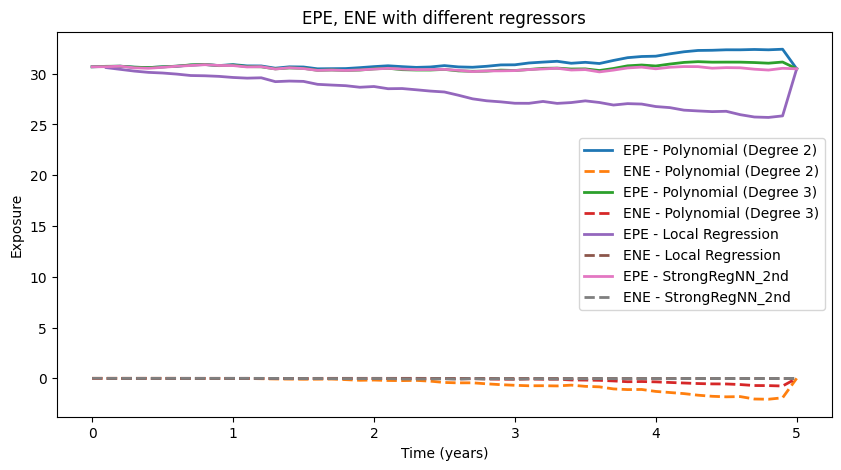

In [10]:
    results = {k: v for k, v in results.items() if k not in ["CNN Regressor", "StrongRegNN_zerofloor"] }
    plt.figure(figsize=(10, 5))
    for name, (EPE, ENE, EE) in results.items():
        plt.plot(np.linspace(0, T, num_steps + 1), EPE, label=f"EPE - {name}", linewidth=2)
        plt.plot(np.linspace(0, T, num_steps + 1), ENE, linestyle="--", label=f"ENE - {name}", linewidth=2)

    plt.title("EPE, ENE with different regressors")
    plt.xlabel("Time (years)")
    plt.ylabel("Exposure")
    plt.legend()
    plt.show()

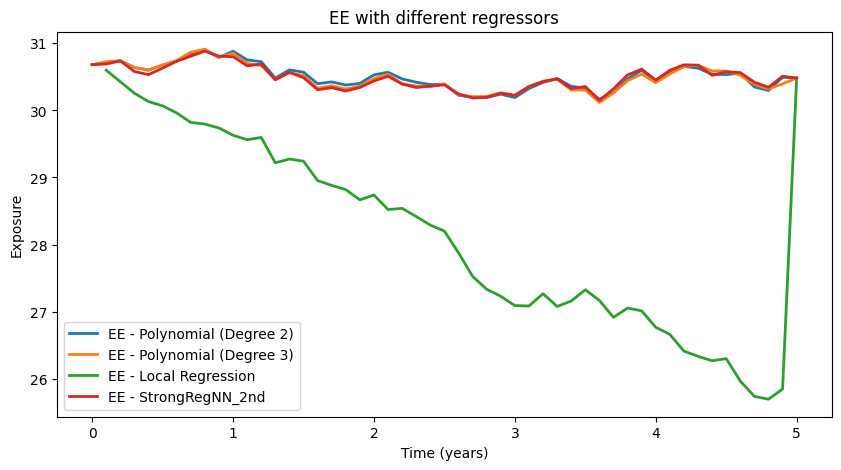

In [11]:
    plt.figure(figsize=(10, 5))
    for name, (EPE, ENE, EE) in results.items():
        plt.plot(np.linspace(0, T, num_steps + 1), EE, label=f"EE - {name}", linewidth=2)

    plt.title("EE with different regressors")
    plt.xlabel("Time (years)")
    plt.ylabel("Exposure")
    plt.legend()
    plt.show()